# Mask Detection with Neural Networks

Author: Umberto Michelucci - umberto.michelucci (at) gmail.com

Version 1.0

The code has been inspired, but simplified and modifed from https://www.pyimagesearch.com.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [5]:
INIT_LR = 1e-4 # learning rate
EPOCHS = 10 # 10 are more than enough to get an accuracy of over 99%
BS = 32 # Batchsize

## Data

We will use for this example data generated by Prajna Bhandary (you can get the data from her [GitHub repository](https://github.com/prajnasb/observations/tree/master/mask_classifier/Data_Generator)). This is a wonderful example of creativity in how to get enough data to train a deep learning model. The masks in the images are not real masks, but are artificially placed on the face of the person in the image, by identifying first the position of relevant landmarks of the face (nose, eyes, etc.) and then placing a "fake" masks on top of the face. 

In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("data"))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # Since we are going to use MobileNetV2 we need to resize the images
    # to the expected size by the pre-trained network.
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


In [7]:
data.shape

(1376, 224, 224, 3)

Now we need to split the dataset to check overfitting and then we can create a `ImageDataGenerator` 
to do data augmentation.

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# Split of data into train and test
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [9]:
# We first load the MobilNetV2 by removing the last layers since
# we want to do transfer learning.
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# The following are the layers we will train
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
# We don't want to train any layer in the MobileNetV2 network
for layer in baseModel.layers:
    layer.trainable = False


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-02-02 17:57:56.419960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-02 17:57:56.420099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


9406464/9406464 [==============================] - 3s 0us/step


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [11]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

/Users/umberto/miniforge3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-02-02 17:58:05.623237: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2023-02-02 17:58:06.335396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 0.4629 - accuracy: 0.8427

2023-02-02 17:58:14.948485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 10s 201ms/step - loss: 0.4629 - accuracy: 0.8427 - val_loss: 0.1840 - val_accuracy: 1.0000
Epoch 2/10
34/34 [==============================] - 5s 155ms/step - loss: 0.1744 - accuracy: 0.9775 - val_loss: 0.0818 - val_accuracy: 1.0000
Epoch 3/10
34/34 [==============================] - 5s 155ms/step - loss: 0.0995 - accuracy: 0.9869 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 4/10
34/34 [==============================] - 5s 154ms/step - loss: 0.0743 - accuracy: 0.9878 - val_loss: 0.0341 - val_accuracy: 1.0000
Epoch 5/10
34/34 [==============================] - 5s 156ms/step - loss: 0.0561 - accuracy: 0.9916 - val_loss: 0.0272 - val_accuracy: 1.0000
Epoch 6/10
34/34 [==============================] - 5s 158ms/step - loss: 0.0440 - accuracy: 0.9916 - val_loss: 0.0243 - val_accuracy: 0.9964
Epoch 7/10
34/34 [==============================] - 5s 154ms/step - loss: 0.0350 - accuracy: 0.9944 - val_loss: 0.0191 - val_accuracy: 1.0000
Epoch 8/10
34/34

A quick reminder

- TP: True Positive
- FP: False Positive
- TN: True Negative
- FN: False Negative


$$
\textrm{PRECISION} = \frac{TP}{TP+FP}
$$


$$
\textrm{RECALL} = \frac{TP}{P} = \frac{TP}{TP+FN}
$$

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))
model.save("model_mask_detection", save_format="h5")

[INFO] evaluating network...


2023-02-02 17:59:04.453617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 87ms/step
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [13]:
model = keras.models.load_model('model_mask_detection')

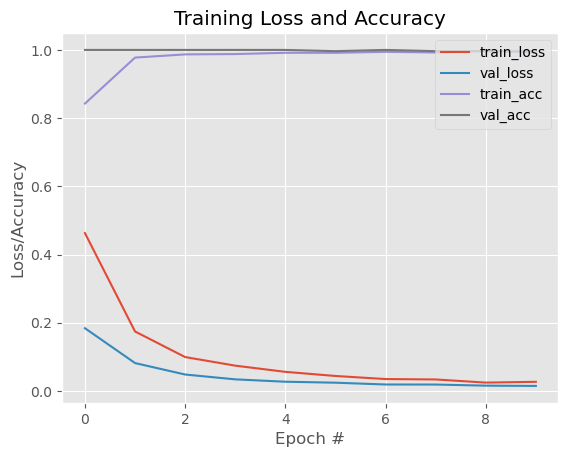

In [14]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("losses.png")

# Test of model

In [15]:
face = cv2.imread('test.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))


face2 = img_to_array(face)
face2 = preprocess_input(face2)
face2 = np.expand_dims(face2, axis=0)
pred = np.argmin(model.predict(face2))
print(pred)

2023-02-02 17:59:06.654646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step
1


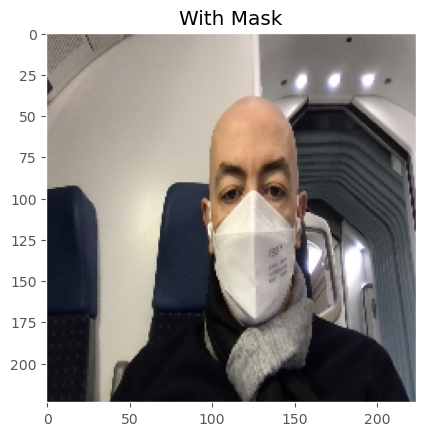

In [16]:
plt.imshow(face)
plt.grid(False)
title = 'With Mask' if (pred == 1) else 'Without Mask'
plt.title(title)
plt.show()

In [17]:
face = cv2.imread('test_no.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))


face2 = img_to_array(face)
face2 = preprocess_input(face2)
face2 = np.expand_dims(face2, axis=0)
pred = np.argmin(model.predict(face2))
print(pred)

1/1 [==============================] - 0s 24ms/step
0


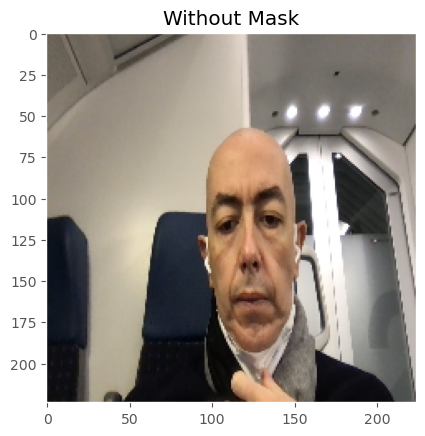

In [18]:
plt.imshow(face)
plt.grid(False)
title = 'With Mask' if (pred == 1) else 'Without Mask'
plt.title(title)
plt.show()

## Example with mask

In [19]:
face = cv2.imread('data/with_mask/0-with-mask.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))


face2 = img_to_array(face)
face2 = preprocess_input(face2)
face2 = np.expand_dims(face2, axis=0)
pred = np.argmin(model.predict(face2))
print(pred)

1/1 [==============================] - 0s 41ms/step
1


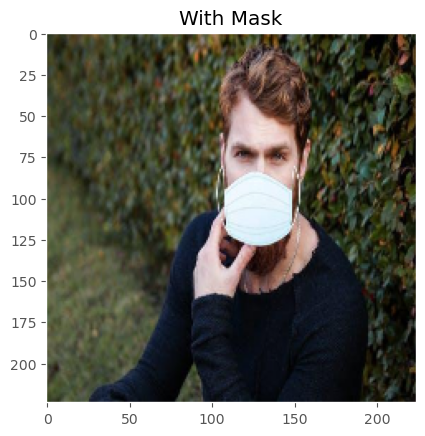

In [20]:
plt.imshow(face)
plt.grid(False)
title = 'With Mask' if (pred == 1) else 'Without Mask'
plt.title(title)
plt.show()

## Example without mask

In [21]:
face = cv2.imread('data/without_mask/0.jpg')
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))


face2 = img_to_array(face)
face2 = preprocess_input(face2)
face2 = np.expand_dims(face2, axis=0)
pred = np.argmin(model.predict(face2))
print(pred)

1/1 [==============================] - 0s 23ms/step
0


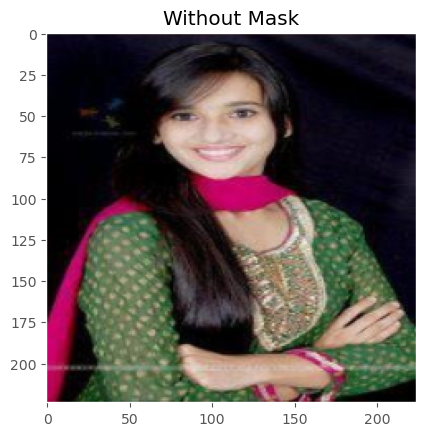

In [22]:
plt.imshow(face)
plt.grid(False)
title = 'With Mask' if (pred == 1) else 'Without Mask'
plt.title(title)
plt.show()

# Improvements and Exercises

1. The training data is limited. More data with different pose and skin colors would increase the accuracy of the model. Can you create a larger dataset with the same approach?
2. The model works best with white masks (the data is using only white masks). Generating images with masks of different colors would increase further the accuracy of the model. Try to trick the model by using different colors of masks. Does the model works equally good? Try to create a larger dataset by using masks of different colors and then train again the model. Can you get better results with masks that are not white?
3. How could you get better? Maybe you could first localize the face and then apply the model you just trained only to the face (and not the entire image). But what happens if the mask covers so much face that you cannot localize it in the image?
4. Can you make the model better to make it work with multiple persons in the image? You have to first implement point 3. and then do a loop over all the faces found. 